In [45]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
from nfft import nfft,ndft

%matplotlib inline

In [3]:
# input_path = '/home/hgrosselindemann/Documents/GitHub/TORI/'
input_path = '/Users/2311043/Documents/GitHub/TORI/'


grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [4]:
t = np.arange(datetime(2015,3,1,0,0,0), datetime(2015,4,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [5]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],t)
},data_vars={
    'u':(['y','x','time'],vel_data['u0_monthly']),
    'v':(['y','x','time'],vel_data['v0_monthly'])
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

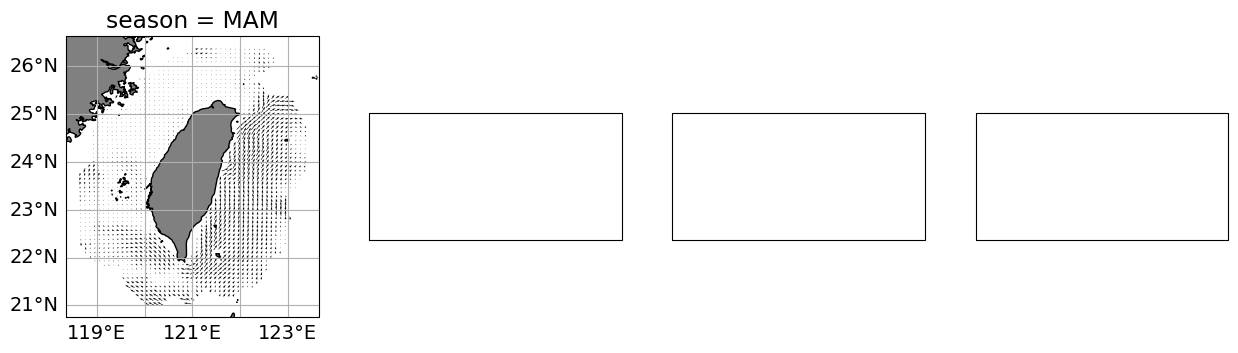

In [139]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.groupby('time.season').mean(dim='time').sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax1)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# Movie

In [9]:
fig = plt.figure(figsize=(10,10))

def custom_plotfunc(ds,fig,tt,framedim='time',**kwargs):
    ax = fig.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ds.isel({framedim:tt}).plot.quiver('lon','lat','u','v',ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
    ax.gridlines(draw_labels=True)
    return None,None
    
# mov = Movie(velocity,custom_plotfunc,input_check=False)
# mov.save('movie_2015.mp4',overwrite_existing=True,framerate=8)

<Figure size 1000x1000 with 0 Axes>

# De-mean and De-trend

In [117]:
def demean_xarray(da,dim):
    return da - da.mean(dim=dim)

def detrend_xarray(da,dim):
    axis_num = [da.get_axis_num(d) for d in dim]
    dt = xr.apply_ufunc(
                linear_detrend,
                da,
                axis_num[0],
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
    return dt
    
def linear_detrend(da,axis):
    ds = da.copy()
    mask = ~np.isnan(ds)
    if mask.sum() == 0:
        return ds
    else:
        ds[mask] = scipy.signal.detrend(ds[mask],axis=axis)
        return ds

In [118]:
u_demeaned = demean_xarray(velocity.u,dim='time')
u_detrended = detrend_xarray(u_demeaned,dim=['time'])

v_demeaned = demean_xarray(velocity.v,dim='time')
v_detrended = detrend_xarray(v_demeaned,dim=['time'])

# Rotary spectrum

In [32]:
def spec_rot(u, v):
    """
    Compute the rotary spectra from u,v velocity components

    Parameters
    ----------
    u : array_like
        zonal wind velocity [m s :sup:`-1`]
    v : array_like
        meridional wind velocity [m s :sup:`-1`]

    Returns
    -------
    cw : array_like
         Clockwise spectrum [TODO]
    ccw : array_like
          Counter-clockwise spectrum [TODO]
    puv : array_like
          Cross spectra [TODO]
    quv : array_like
          Quadrature spectra [ TODO]

    Notes
    -----
    The spectral energy at some frequency can be decomposed into two circularly
    polarized constituents, one rotating clockwise and other anti-clockwise.

    Examples
    --------
    TODO: puv, quv, cw, ccw = spec_rot(u, v)

    References
    ----------
    J. Gonella Deep Sea Res., 833-846, 1972.

    """

    # Individual components Fourier series.
    fu, fv = list(map(np.fft.fft, (u, v)))

    # Auto-spectra of the scalar components.
    pu = fu * np.conj(fu)
    pv = fv * np.conj(fv)

    # Cross spectra.
    puv = fu.real * fv.real + fu.imag * fv.imag

    # Quadrature spectra.
    quv = -fu.real * fv.imag + fv.real * fu.imag

    # Rotatory components
    # TODO: Check the division, 4 (original code) or 8 (paper)?
    cw = (pu + pv - 2 * quv) / 4.
    ccw = (pu + pv + 2 * quv) / 4.
    N = len(u)
    F = np.arange(0, N) / N
    return puv, quv, cw, ccw, F

In [33]:
mask = ~np.isnan(u_detrended[:,10,10])

puv, quv, cw, ccw, F = spec_rot(u_detrended[:,10,10][mask],v_detrended[:,10,10][mask])

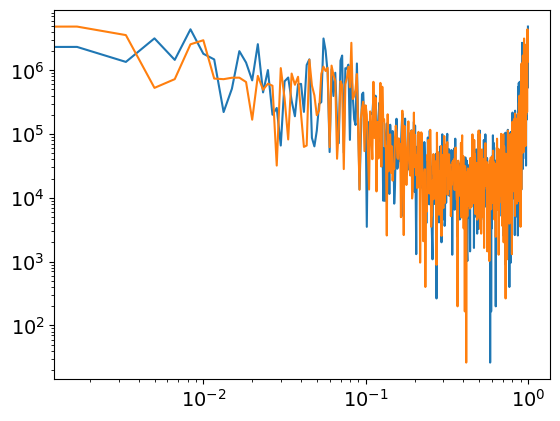

In [35]:
plt.loglog(F,cw)
plt.loglog(F,ccw)

In [119]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

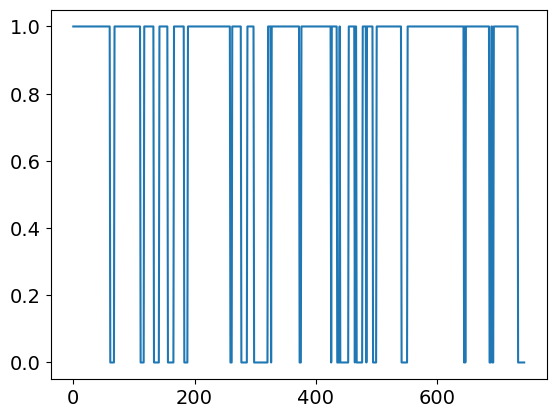

In [125]:
plt.plot(mask)

In [132]:
mask = ~np.isnan(u_detrended[:,10,10])

freq,ps,psd = spectrum1(u_detrended[:,10,10])

In [134]:
freq.min()

0.0013440860215053765

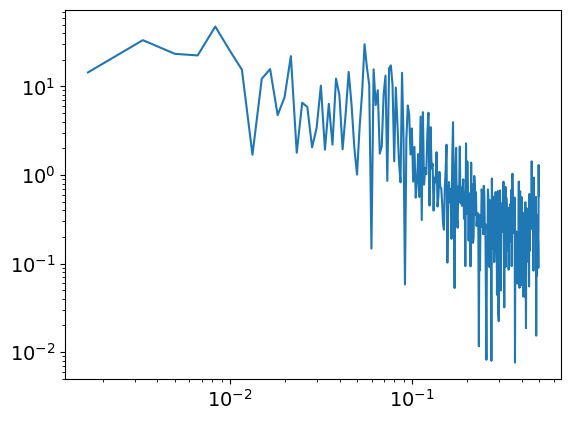

In [121]:
plt.loglog(freq,ps)

In [19]:
fu, fv = list(map(np.fft.fft, (u_detrended[:,10,10].data,v_detrended[:,10,10].data)))

In [89]:
data = velocity.u[:,10,10].rolling(time=5).mean().data
mask = ~np.isnan(data)
data_masked = data[mask]
len(data_masked)

519

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

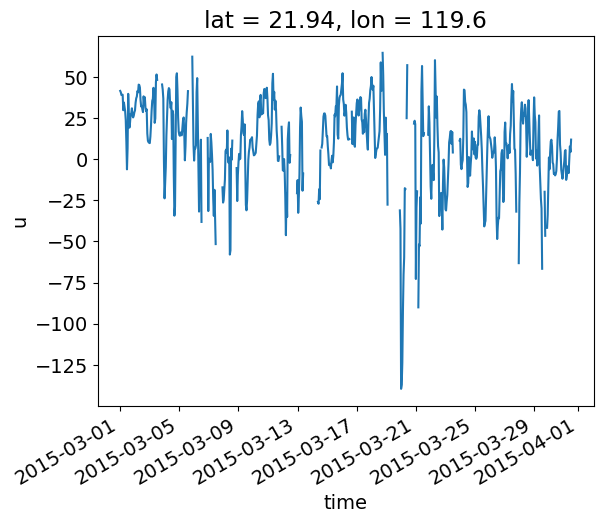

In [90]:
velocity.u[:,10,10].plot()
data.plot()


In [91]:
seconds_per_hour = 60*60
time = np.arange(0,seconds_per_hour*744,seconds_per_hour)
time_masked = time[mask]

In [102]:
from pynufft import NUFFT
NufftObj = NUFFT()

om = np.random.randn(1512,1)
Nd = (len(data_masked),)
Kd = (744,)
Jd = (1,)

NufftObj.plan(om, Nd, Kd, Jd)



0

In [103]:
nufft_freq_data =NufftObj.forward(data_masked)

In [ ]:
powerspectrum = np.abs(nufft_freq_data)**2/601**2


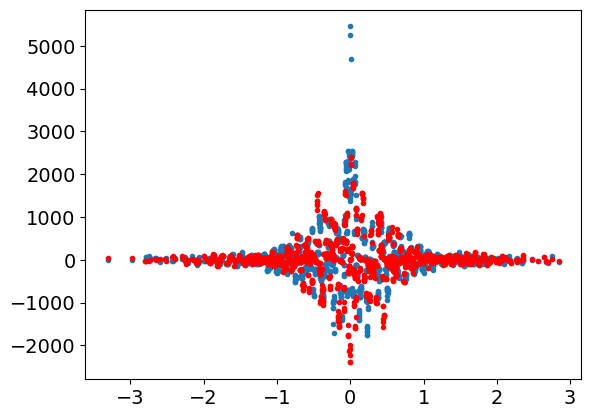

In [104]:
plt.plot(om,nufft_freq_data.real,'.')
plt.plot(om,nufft_freq_data.imag,'r.')


In [105]:
restore_time = NufftObj.solve(nufft_freq_data,'cg', maxiter=30)

(0.0, 200.0)

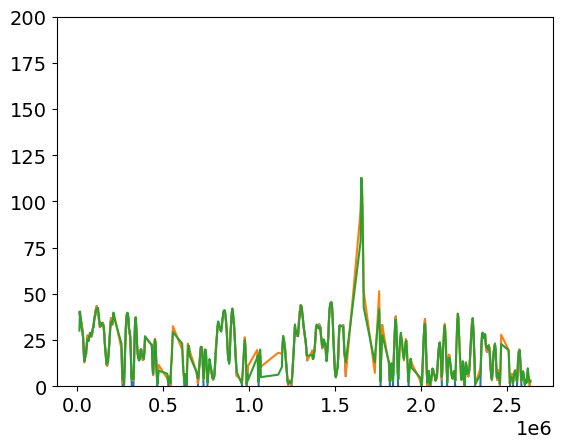

In [106]:
plt.plot(time,data)
plt.plot(time_masked,np.abs(data_masked))
plt.plot(time_masked,np.abs(restore_time))
plt.ylim([0,200])

C:\Users\2311043\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-200.0, 200.0)

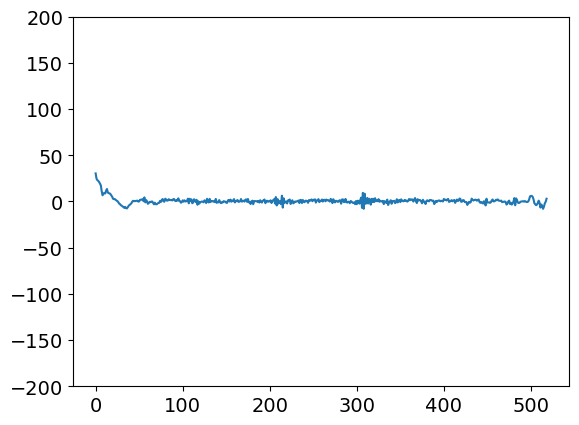

In [97]:
plt.plot(data_masked-restore_time)
plt.ylim([-200,200])

In [101]:
NufftObj.plan?

Signature: NufftObj.plan(*args, **kwargs)
Docstring:
Plan the NUFFT object with the geometry provided.

:param om: The M off-grid locates in the frequency domain,
            which is normalized between [-pi, pi]
:param Nd: The matrix size of the equispaced image.
           Example: Nd=(256,256) for a 2D image;
                     Nd = (128,128,128) for a 3D image
:param Kd: The matrix size of the oversampled frequency grid.
           Example: Kd=(512,512) for 2D image;
                    Kd = (256,256,256) for a 3D image
:param Jd: The interpolator size.
           Example: Jd=(6,6) for 2D image;
                    Jd = (6,6,6) for a 3D image
:param ft_axes: (Optional) The axes for Fourier transform.
                The default is all axes if 'None' is given.
:type om: numpy.float array, matrix size = M * ndims
:type Nd: tuple, ndims integer elements.
:type Kd: tuple, ndims integer elements.
:type Jd: tuple, ndims integer elements.
:type ft_axes: None, or tuple with optional inte

# Parcels

In [196]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

In [149]:
velocity.u.to_netcdf('/Users/2311043/Documents/TOROS_U_0315.nc')
velocity.v.to_netcdf('/Users/2311043/Documents/TOROS_V_0315.nc')

In [197]:
filenames = {'U': "/Users/2311043/Documents/TOROS_U_0315.nc",
             'V': "/Users/2311043/Documents/TOROS_V_0315.nc"}
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [198]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=5,            # releasing 5 particles
                             start=(121, 22),   # releasing on a line: the start longitude and latitude
                             finish=(121.5, 22))  # releasing on a line: the end longitude and latitude

In [199]:
output_file = pset.ParticleFile(name="/Users/2311043/Documents/TOROS_Parcels/toros.zarr", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=1),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\2311043\AppData\Local\Temp\parcels-tmp\lib0cef196e3e2f85a18c88e5a9d3aa42fb_0.dll


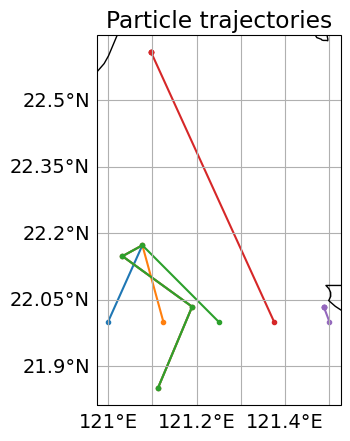

<module 'matplotlib.pyplot' from 'C:\\Users\\2311043\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [200]:
plotTrajectoriesFile("/Users/2311043/Documents/TOROS_Parcels/toros.zarr")

In [201]:
data = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros.zarr").load()

In [203]:
data

<xarray.Dataset>
Dimensions:     (trajectory: 5, obs: 5)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4
  * trajectory  (trajectory) int64 35 36 37 38 39
Data variables:
    lat         (trajectory, obs) float32 22.0 22.17 22.15 ... 22.03 22.03 22.03
    lon         (trajectory, obs) float32 121.0 121.1 121.0 ... 121.5 121.5
    time        (trajectory, obs) datetime64[ns] 2015-03-01 ... 2015-03-02
    z           (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.1

In [ ]:
EG010430194TW